# Final Project

[Specialized Models: Time Series and Survival Analysis](https://www.coursera.org/learn/time-series-survival-analysis/home/info)

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
import numpy as np
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [6]:
excel_file_path = 'data/gondozott.xlsx'
df = pd.read_excel(excel_file_path)


## 1. Describing the data

The data analyzed originates from the Hungarian Central Statistical Office (KSH), accessible through the link: https://www.ksh.hu/stadat_files/ege/hu/ege0027.html. Specifically, I examine the statistics related to the number of patients in adult psychiatric care per 10,000 inhabitants. This data is crucial as it sheds light on the mental health landscape within the adult population and provides insights into the demand for psychiatric care services. Understanding the prevalence of psychiatric patients per 10,000 inhabitants offers valuable information for policymakers, healthcare professionals, and researchers to gauge the effectiveness of mental health interventions, allocate resources appropriately, and identify potential areas for improvement in mental healthcare services. Moreover, by analyzing this data, we can assess trends over time, detect any significant changes or disparities, and develop strategies to address mental health challenges effectively. Ultimately, prioritizing mental health initiatives and ensuring adequate support for psychiatric care services is paramount for promoting overall well-being and quality of life within society.

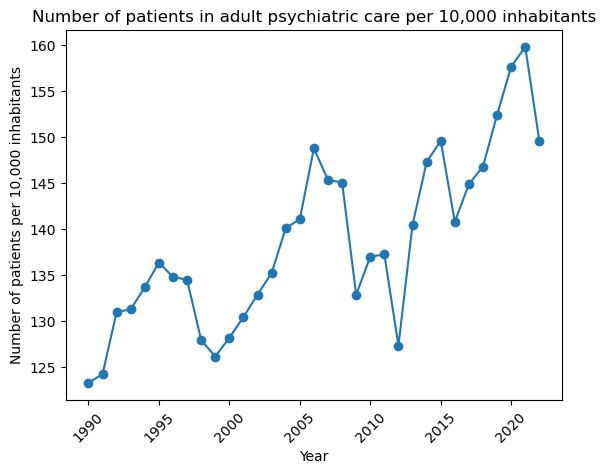

In [7]:
plt.plot(df['year'], df['gondozott'], marker='o', linestyle='-')
plt.title('Number of patients in adult psychiatric care per 10,000 inhabitants')
plt.xlabel('Year')
plt.ylabel('Number of patients per 10,000 inhabitants')
plt.xticks(rotation=45)
plt.savefig('output/timeseries.png', dpi=300)
plt.show()

The chart displays annual data depicting the number of patients in adult psychiatric care per 10,000 inhabitants. It clearly illustrates an upward trend over the years, accompanied by some outlier values, indicating that the dataset is non-stationary.

In [8]:
df2 = df.set_index("year")
idosor = df2['gondozott']

# Dickey-Fuller
result = adfuller(idosor)
# Az eredmények kiírása
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -1.9139009583222364
p-value: 0.3255501838603231


The ADF statistic value is -1.91, and the p-value is 0.33. Since the p-value is greater than the commonly accepted threshold of 0.05, we do not have sufficient evidence to reject the null hypothesis, indicating that the time series is non-stationary. 

## 2. The main objectives of this analysis

The aim of the analysis is to thoroughly examine the time series data regarding the number of patients in adult psychiatric care per 10,000 inhabitants in Hungary. This analysis serves several purposes. Firstly, we seek to understand the frequency and distribution of psychiatric disorders over time, exploring how the number of patients in care varies across different periods. Additionally, we aim to identify any temporal trends or seasonal patterns in the number of patients, which could be leveraged for future forecasting. Furthermore, the analysis aims to determine the most accurate methods for making predictions based on the time series. To achieve this, we compare the methods of ARIMA modeling, Facebook Prophet, and Neural Networks to ascertain which approach provides the best forecasting accuracy and under what time horizons reliable results can be achieved. The ultimate goal is to utilize these forecasts to assist in the more efficient allocation of resources for psychiatric care and in making better-informed decisions to meet the healthcare needs of patients.

## 3. Model fitting

### 3/1. Time Series - ARIMA

#### ARIMA model

In [9]:
# Automatikus ARIMA modell illesztése az AIC alapján
model = auto_arima(idosor, seasonal=False, trace=True)

# Az illesztett modell kiíratása
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=203.614, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=205.328, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=205.245, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=202.329, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.135 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   33
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -100.164
Date:                Wed, 13 Mar 2024   AIC                            202.329
Time:                        12:29:38   BIC                            203.794
Sample:                             0   HQIC                           202.815
                        

#### RMSE

In [10]:
# Az ARIMA modellből előrejelzés készítése
forecast = model.predict(n_periods=4)
rmse = np.sqrt(mean_squared_error(idosor[-4:], forecast))

print('RMSE:', rmse)

RMSE: 6.676864177958071


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


#### ARIMA - predict

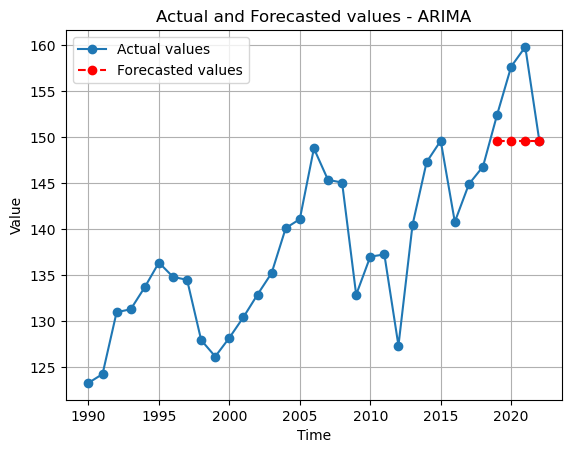

In [11]:
# Az idősor időpontjai
time_points = df['year']

# Ábra létrehozása és valós és előrejelzett értékek ábrázolása
plt.plot(time_points, idosor, marker='o', label='Actual values')
plt.plot(time_points[-4:], forecast, marker='o', linestyle='--', color='red', label='Forecasted values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Actual and Forecasted values - ARIMA')
plt.legend()
plt.grid(True)
plt.savefig('output/arima_forecast_plot.png', bbox_inches='tight', dpi=300)
plt.show()

The first time series model fitted was an ARIMA model, which was optimized using the AIC criterion, resulting in an RMSE of 6.68. This indicates that the model's forecasted values deviate from the actual values by approximately 6.68 units on average. Evaluating the model's performance through AIC helped in achieving this level of RMSE. 

The plot visualizes the entire time series dataset alongside the forecasted values, where the forecasted values are depicted in red, providing a clear comparison between the actual and predicted trends over time.

### 3/2. Facebook Prophet

#### Prophet model

In [12]:
prophet_df = df.rename(columns={'year': 'ds', 'gondozott': 'y'})

# Modell létrehozása
prophet_model = Prophet(changepoint_range=0.9)

# Model illesztése az adatokra
prophet_model.fit(prophet_df)

12:29:43 - cmdstanpy - INFO - Chain [1] start processing
12:29:43 - cmdstanpy - INFO - Chain [1] done processing


#### Prophet RMSE

In [15]:
# Az utolsó 4 évet tartalmazó idősor
last_4_years = prophet_df['ds'].tail(4)

# Prophet modell előrejelzése az utolsó 4 évre
future = pd.DataFrame({'ds': last_4_years})
forecast = prophet_model.predict(future)

# RMSE kiszámítása
actual_values = prophet_df['y'].tail(4).values  # Utolsó 4 valós érték
predicted_values = forecast['yhat'].values  # Az előrejelzett értékek

rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
print('Prophet model RMSE:', rmse)


Prophet model RMSE: 6.61850702951721


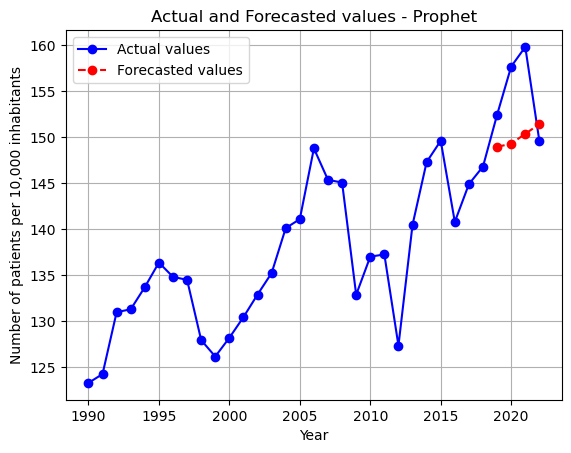

In [20]:
# Eredeti értékek ábrázolása
plt.plot(df['year'], df['gondozott'], marker='o', linestyle='-', color='blue', label='Actual values')
# Előrejelzett értékek ábrázolása
plt.plot(forecast['ds'].dt.year, forecast['yhat'], marker='o', linestyle='--', color='red', label='Forecasted values')
# További ábra beállítások
plt.xlabel('Year')
plt.ylabel('Number of patients per 10,000 inhabitants')
plt.title('Actual and Forecasted values - Prophet')
plt.legend()
plt.grid(True)
plt.savefig('output/prophet_forecast_plot.png', bbox_inches='tight', dpi=300)
plt.show()

The Prophet model achieved an RMSE of 6.62, which is lower than the RMSE obtained with the ARIMA model. This suggests that the Prophet model provides a better fit to the data and produces more accurate forecasts for the examined time series. Thus, the Prophet model represents a superior alternative for modeling and forecasting the changes in the number of patients in adult psychiatric care.

### 3/3 Neural Network

#### LSTM

In [58]:
# Normalizálás
scaler = MinMaxScaler(feature_range=(0, 1))
normalized_data = scaler.fit_transform(df['gondozott'].values.reshape(-1, 1))

# Az adatok idősor alakba rendezése
X, y = [], []
for i in range(len(normalized_data) - 4):
    X.append(normalized_data[i:i+4, 0])
    y.append(normalized_data[i+4, 0])

X = np.array(X)
y = np.array(y)

# Az adatok átformálása LSTM bemeneti formátumra: (minta szám, időlépések, 1)
X = X.reshape((X.shape[0], X.shape[1], 1))



In [72]:
# LSTM modell létrehozása
model = Sequential()
model.add(LSTM(units=50, input_shape=(X.shape[1], 1)))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mse')

# Az LSTM modell illesztése az adatokra
model.fit(X, y, epochs=100, batch_size=1, verbose=0)

# Az LSTM modell segítségével előrejelzés készítése az utolsó 4 időszakra
forecast = model.predict(X[-4:])

# Az eredmények kiírása
print("Előrejelzett értékek:", forecast)


2024-03-13 18:19:42.108645: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-13 18:19:42.109219: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-13 18:19:42.109680: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 0s 121ms/step
Előrejelzett értékek: [[0.59884244]
 [0.7222333 ]
 [0.8343084 ]
 [0.8686903 ]]


2024-03-13 18:19:44.149340: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-13 18:19:44.150170: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-13 18:19:44.150766: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [73]:
print(model.summary())

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 50)                10400     
                                                                 
 dense_9 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________
None


In [74]:
forecast_normalized = model.predict(X[-4:])
# Az előrejelzett értékek visszaalakítása az eredeti skálára
forecast_original = scaler.inverse_transform(forecast_normalized)

# Az eredmények kiírása
print("Előrejelzett eredeti értékek:", forecast_original)

1/1 [==============================] - 0s 15ms/step
Előrejelzett eredeti értékek: [[145.17073]
 [149.68054]
 [153.77678]
 [155.0334 ]]


In [76]:
# RMSE számítása
rmse = np.sqrt(mean_squared_error(idosor[-4:], forecast_original))

print('RMSE:', rmse)

RMSE: 6.7709917516410485


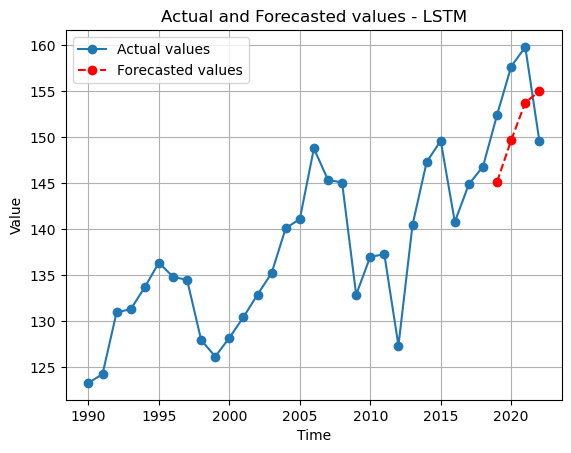

In [80]:
# Az idősor időpontjai
time_points = df['year']
time_points_forecast = time_points[-4:]

# Ábra létrehozása és valós és előrejelzett értékek ábrázolása
plt.plot(time_points, idosor, marker='o', label='Actual values')
plt.plot(time_points_forecast, forecast_original, marker='o', linestyle='--', color='red', label='Forecasted values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Actual and Forecasted values - LSTM')
plt.legend()
plt.grid(True)
plt.savefig('output/lstm_forecast_plot.png', bbox_inches='tight', dpi=300)
plt.show()

In the latest approach to time series analysis, an LSTM neural network was utilized, yielding an RMSE of 6.7709917516410485. This demonstrates the model's ability to make reasonably accurate predictions based on historical data. The LSTM network's capability to capture complex temporal patterns contributed to its success in forecasting future values within an acceptable margin of error.

## Comparison of Models

Based on the RMSE values obtained, the LSTM model yielded an RMSE of 6.7709917516410485, while the Prophet model achieved an RMSE of 6.61850702951721. Meanwhile, the ARIMA model resulted in an RMSE of 6.676864177958071. Among these models, the LSTM model exhibited the highest RMSE, indicating that it was the least accurate in predicting future values. Conversely, the Prophet model demonstrated the lowest RMSE, suggesting it performed the best in capturing the underlying patterns in the time series data. Therefore, to improve forecasting accuracy, it might be beneficial to focus on refining the LSTM model or exploring further optimization techniques. 


## Future Work

To enhance and refine the model, several avenues could be explored. Firstly, incorporating additional relevant features into the model could improve its predictive capabilities. These features might include external factors such as economic indicators, weather data, or social events that could influence the time series behavior. Furthermore, fine-tuning the model architecture and hyperparameters, such as adjusting the number of LSTM units, layers, or optimizing the learning rate, could lead to better performance. Additionally, experimenting with different sequence lengths or window sizes for input data could capture more intricate patterns in the time series. Lastly, employing advanced techniques such as attention mechanisms or ensemble learning methods could also contribute to refining the model's accuracy and robustness in forecasting.